In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
from sklearn import mixture

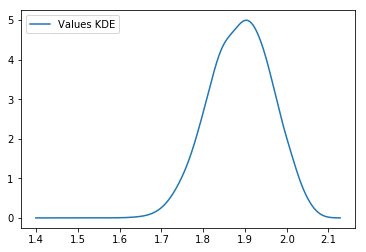

In [2]:
#draw data
n=2000

bids = np.concatenate((np.random.normal(loc=1.7, scale=0.06, size=int(.8*n)), 
                      np.random.normal(loc=1.9, scale=0.07, size=int(.2*n))))

#fit mixture model
g = mixture.GaussianMixture(n_components=2)
g.fit(bids.reshape(n,1))
ind =  np.argmax(g.means_, axis=0)[0]


#print values given competitive distribution
i = 7
g1 = lambda b: scipy.stats.norm.pdf(b,g.means_[ind,0],g.covariances_[ind,0]**.5)
G1 = lambda b: scipy.stats.norm.pdf(b,g.means_[ind,0],g.covariances_[ind,0]**.5)
values = bids + 1/(i-1)*G1(bids)/g1(bids)

#KDE_weighted
q = g.predict_proba(bids.reshape(n,1))[:,ind]
kde = sm.nonparametric.KDEUnivariate(values)

kde.fit(weights=q, fft=False)
plt.plot(kde.support, kde.density, label='Values KDE')

plt.legend()
plt.show()

In [4]:
def interp_cdf(x,kde):
    """apparantly this isn't in statsmodels, want to make sure this is smooth"""
    
    #make sure this is safe
    if kde.support.min() > x:
        return np.array([0])
    if kde.support.max() < x:
        return np.array([-1])
    
    x_left = kde.support[kde.support < x][-1]
    x_right = kde.support[kde.support > x][0]
    
    cdf_left = kde.cdf[kde.support < x][-1]
    cdf_right = kde.cdf[kde.support > x][0]    
    return cdf_left + (x-x_left)*(cdf_right-cdf_left)/(x_right-x_left)
 
    
print interp_cdf(np.array([1.8]),kde)

[0.12666243]


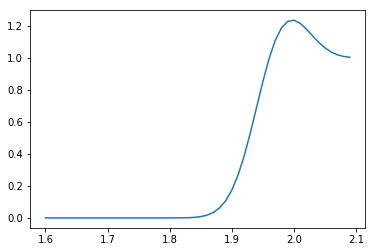

In [48]:
def pi_l(p, vs, i, kde):
    """lower bound for profits"""
    pi = []
    for q in p:
        q_cdf = interp_cdf(np.array([q]),kde)
        pi_q = vs*q_cdf**i + i*q*(1-q_cdf)*q_cdf**(i-1)
        pi = np.concatenate((pi,pi_q))   
    return pi
    


support = np.arange(1.6,2.1,.01)
vs = values.min()

#first plot overall bounds
lb = pi_l(support, 1, i, kde)
plt.plot(support, lb, label='Lower Bound')
plt.show()

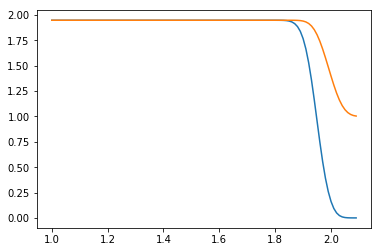

In [49]:
def pi_u(p, vs, i, kde):
    """upper bound for profits"""
    integrand = i*(i-1)*(1-kde.cdf)*kde.support*(kde.cdf)**(i-2)*kde.density
    integrand = scipy.interpolate.BSpline(kde.support, integrand, 1)
    surplus = []
    
    for q in p:
        
        integral =  integrand.integrate(q, kde.support.max())
        surplus = np.concatenate((surplus, [integral]))
        
    return pi_l(p, vs, i, kde) + surplus, surplus


support = np.arange(1.0,2.1,.01)
vs = values.min()

#first plot overall bounds
ub,surplus = pi_u(support, 1, i, kde)
plt.plot(support, surplus, label='Surplus')
plt.plot(support, ub, label='Upper Bound')
plt.show()

In [ ]:
def pi_opt(vs, i, dist, supp):
    """argmax of lower bound"""
    obj = lambda p: -pi_l(p, vs, i, dist, supp)
    result = scipy.optimize.minimize(obj, sum(supp)/2.)
    return result.x, -1*obj(result.x)


def pi_est(vs, i, dist, supp):
    """calculate the """
    argmax, maxim = pi_opt(vs, i, dist, supp)
   
    obj = lambda p:(pi_u(p, vs, i, dist, supp) - maxim)**2

    bnds1 = [(supp[0],argmax)]
    result1 = scipy.optimize.minimize(obj, argmax*.9, bounds=bnds1 )
    
    bnds2 = [(argmax,supp[1])]
    result2 = scipy.optimize.minimize(obj, argmax*1.1, bounds=bnds2 )

    return np.concatenate([result1.x, result2.x])

In [ ]:

#bounds on reserve price
argmax, maxim = pi_opt(1, i, values_dist, values_supp)
p_bnds = pi_est(1, i, values_dist, values_supp)
pi_bnds = pi_u(p_bnds, 1, i, values_dist, values_supp)

plt.plot(p_bnds, pi_bnds, label='Price Bounds',marker='o')
plt.plot(argmax, maxim, label='Min, Max Profit',marker='o')


#make it pretty
plt.xlabel('Reserve Price')
plt.ylabel('Optimal Profits')
plt.title('Reserve Price against Profits')
plt.legend()
plt.show()

In [ ]:
#spline vs interpolation
spline_pdf = scipy.interpolate.BSpline(kde.support, kde.density, 1)
interp_pdf = scipy.interpolate.interp1d(kde.support,  kde.density, fill_value="extrapolate")

plt.plot(kde.support, spline_pdf(kde.support), label='Spline')
plt.plot(kde.support, interp_pdf(kde.support), label='Interp')
plt.legend()
plt.show()

#check cdf
spline_cdf = scipy.interpolate.BSpline(kde.support, kde.cdf, 1)
interp_cdf = scipy.interpolate.interp1d(kde.support,  kde.cdf, fill_value="extrapolate")

plt.plot(kde.support, spline_cdf(kde.support), label='Spline')
plt.plot(kde.support, interp_cdf(kde.support), label='Interp')
plt.legend()
plt.show()

In [ ]:
values_dist = scipy.stats.rv_continuous()

#set up values distribution as a rvs
values_dist.cdf  = scipy.interpolate.BSpline(kde.support, kde.cdf, 1)
values_dist.pdf = scipy.interpolate.BSpline(kde.support,  kde.density, 1)

#helps with integrating
values_dist.a = kde.support.min()
values_dist.b = kde.support.max()

plt.plot(kde.support, values_dist.pdf(kde.support), label='Values Interpolated')
plt.legend()
plt.show()